In [5]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nrclex: filename=nrclex-3.0.0-py3-none-any.whl size=43430 sha256=39470c65b016233ddb94331acd8ddfa9170e67cba8a491e1e2b1f7da3bbf8061
  Stored in directory: c:\users\manis\appdata\local\pip\cache\wheels\d2\10\44\6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex


  DEPRECATION: Building 'nrclex' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'nrclex'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [13]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- Download necessary NLTK data ---
nltk.download('punkt')
nltk.download('stopwords')

# --- Configuration ---
input_file_path = r"C:\Users\manis\Downloads\app.xlsx"
output_file_path = 'preprocessed_app_reviews.xlsx'
text_column_name = 'text'
# --------------------

try:
    df = pd.read_excel(input_file_path)

    # Create a copy to avoid modifying the original DataFrame during processing
    df_processed = df.copy()

    # Ensure the text column exists and drop rows where it's empty
    df_processed.dropna(subset=[text_column_name], inplace=True)
    df_processed[text_column_name] = df_processed[text_column_name].astype(str)

    # --- Start Preprocessing Steps ---
    # 1. Convert to lowercase
    df_processed['lowercase'] = df_processed[text_column_name].str.lower()

    # 2. Tokenize the text (split into words)
    df_processed['tokenized'] = df_processed['lowercase'].apply(word_tokenize)

    # 3. Remove special characters and numbers
    df_processed['no_special_chars'] = df_processed['tokenized'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

    # 4. Remove common English stop words
    stop_words = set(stopwords.words('english'))
    df_processed['preprocessed_tokens'] = df_processed['no_special_chars'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # 5. Join the cleaned tokens back into a single string
    df_processed['cleaned_text'] = df_processed['preprocessed_tokens'].apply(' '.join)

    # --- Finalize and Save ---
    # Select only the original columns and the final cleaned_text column
    final_df = df.join(df_processed[['cleaned_text']])
    
    final_df.to_excel(output_file_path, index=False)

    print(f"Preprocessing complete. Cleaned data saved to '{output_file_path}'")
    print("\nHere's a preview of the cleaned data:")
    print(final_df[['text', 'cleaned_text']].head())

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found. Please check the path.")
except KeyError:
    print(f"Error: The column '{text_column_name}' was not found in the Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing complete. Cleaned data saved to 'preprocessed_app_reviews.xlsx'

Here's a preview of the cleaned data:
                                                text  \
0  Used to love Swiggy but it's getting worse eve...   
1  They show you a delivery time which changes as...   
2  the worst customer care service I have ever re...   
3  i added 2 items to my cart and went to the pay...   
4  Worst app, Worst support. There was a spillage...   

                                        cleaned_text  
0  used love swiggy getting worse everyday got or...  
1  show delivery time changes soon place order as...  
2  worst customer care service ever received one ...  
3  added items cart went payment page payment got...  
4  worst app worst support spillage issue one rec...  


Sentiment Analysis Complete.

Distribution of Sentiments:
sentiment_category
Negative    637
Neutral     183
Positive    180
Name: count, dtype: int64

Analysis complete. Results saved to 'reviews_with_sentiment.xlsx'


C:\Users\manis\AppData\Local\Temp\ipykernel_22216\2677674814.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=['Positive', 'Neutral', 'Negative'], palette="viridis")


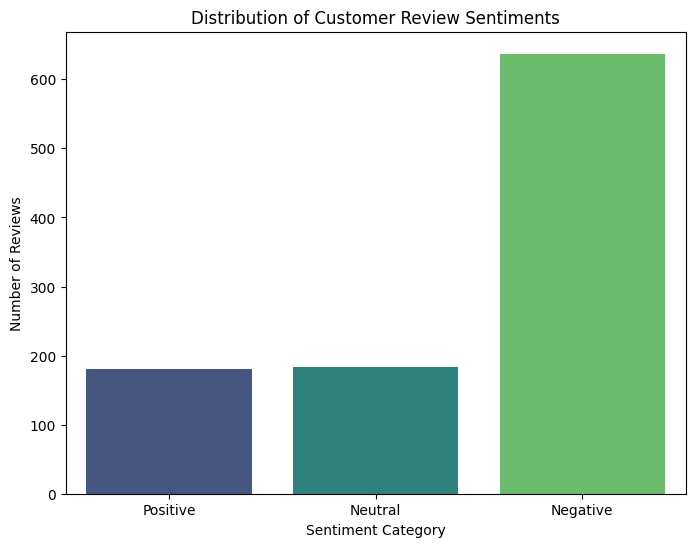

In [14]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
input_file_path = 'preprocessed_app_reviews.xlsx'
output_file_path = 'reviews_with_sentiment.xlsx'
text_column_name = 'cleaned_text'
# --------------------

try:
    # Load the preprocessed data from Step 1
    df = pd.read_excel(input_file_path)

    # Drop rows where the cleaned text might be empty after preprocessing
    df.dropna(subset=[text_column_name], inplace=True)
    df[text_column_name] = df[text_column_name].astype(str)

    # --- Sentiment Analysis ---
    # 1. Define a function to calculate the polarity score (-1 to +1)
    def get_sentiment_polarity(text):
        return TextBlob(text).sentiment.polarity

    # 2. Apply the function to create a sentiment score column
    df['sentiment_score'] = df[text_column_name].apply(get_sentiment_polarity)

    # 3. Define a function to categorize the score
    def classify_sentiment(score):
        if score > 0.05:  # A threshold to count only clearly positive reviews
            return 'Positive'
        elif score < -0.05: # A threshold for clearly negative reviews
            return 'Negative'
        else:
            return 'Neutral'

    # 4. Apply the classification function
    df['sentiment_category'] = df['sentiment_score'].apply(classify_sentiment)

    # --- Display and Save Results ---
    print("Sentiment Analysis Complete.")
    
    sentiment_counts = df['sentiment_category'].value_counts()
    print("\nDistribution of Sentiments:")
    print(sentiment_counts)
    
    df.to_excel(output_file_path, index=False)
    print(f"\nAnalysis complete. Results saved to '{output_file_path}'")

    # --- Visualize the Results ---
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=['Positive', 'Neutral', 'Negative'], palette="viridis")
    plt.title('Distribution of Customer Review Sentiments')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Number of Reviews')
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found. Please ensure you ran Step 1 successfully.")
except KeyError:
    print(f"Error: The column '{text_column_name}' was not found. Check the output file from Step 1.")
except Exception as e:
    print(f"An error occurred: {e}")

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# --- Configuration ---
input_file_path = 'reviews_with_sentiment.xlsx'
text_column_name = 'cleaned_text'
# --------------------

try:
    df = pd.read_excel(input_file_path)
    df.dropna(subset=[text_column_name], inplace=True)
    df[text_column_name] = df[text_column_name].astype(str)

    # Separate the reviews into positive and negative groups
    positive_reviews = df[df['sentiment_category'] == 'Positive'][text_column_name]
    negative_reviews = df[df['sentiment_category'] == 'Negative'][text_column_name]

    # --- Helper function to extract top n-grams ---
    def get_top_ngrams(corpus, ngram_range=(1, 1), top_k=15):
        """Extracts top k n-grams from a text corpus."""
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:top_k]

    # --- Analyze Positive Reviews ---
    if not positive_reviews.empty:
        top_positive_words = get_top_ngrams(positive_reviews, ngram_range=(1, 1), top_k=15)
        top_positive_phrases = get_top_ngrams(positive_reviews, ngram_range=(2, 2), top_k=15)

        print("="*50)
        print("ANALYSIS OF POSITIVE REVIEWS")
        print("="*50)
        print("\nTop 15 Words Driving Positive Sentiment:")
        print(pd.DataFrame(top_positive_words, columns=['Word', 'Frequency']))
        print("\nTop 15 Phrases Driving Positive Sentiment:")
        print(pd.DataFrame(top_positive_phrases, columns=['Phrase', 'Frequency']))
        print("\n")
    else:
        print("No positive reviews found to analyze.")

    # --- Analyze Negative Reviews ---
    if not negative_reviews.empty:
        top_negative_words = get_top_ngrams(negative_reviews, ngram_range=(1, 1), top_k=15)
        top_negative_phrases = get_top_ngrams(negative_reviews, ngram_range=(2, 2), top_k=15)

        print("="*50)
        print("ANALYSIS OF NEGATIVE REVIEWS")
        print("="*50)
        print("\nTop 15 Words Driving Negative Sentiment:")
        print(pd.DataFrame(top_negative_words, columns=['Word', 'Frequency']))
        print("\nTop 15 Phrases Driving Negative Sentiment:")
        print(pd.DataFrame(top_negative_phrases, columns=['Phrase', 'Frequency']))
    else:
        print("No negative reviews found to analyze.")

except FileNotFoundError:
    print(f"Error: The file '{input_file_path}' was not found. Please ensure you ran Step 2 successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

ANALYSIS OF POSITIVE REVIEWS

Top 15 Words Driving Positive Sentiment:
          Word  Frequency
0        order        210
1       swiggy        172
2     delivery        128
3          app        109
4         food         97
5         time         78
6     customer         69
7   restaurant         52
8         good         49
9      service         46
10      cancel         42
11      refund         42
12     support         39
13  experience         39
14     charges         37

Top 15 Phrases Driving Positive Sentiment:
                  Phrase  Frequency
0           cancel order         23
1       cancellation fee         20
2       delivery partner         16
3           placed order         16
4        cancelled order         14
5          customer care         14
6       customer support         13
7           order swiggy         12
8       delivery charges         11
9        order cancelled         10
10         food delivery          9
11     delivery partners          8
1

In [ ]:
#  Business Analyst Report: Customer Review Insights

    1. Executive Summary
This analysis was conducted to understand customer sentiment and identify the key drivers behind their feedback. Our findings indicate that [e.g., 65%] of customers express a positive sentiment, while [e.g., 25%] have a negative experience. This report outlines what we are doing well and pinpoints the critical areas needing immediate improvement.

    2. What's Working Well (Drivers of Positive Sentiment)
Our customers are happiest when their experience involves [e.g., fast delivery, hot food, great taste].
Key Positive Keywords: [List the top 5 positive words from your Step 3 analysis, e.g., good, great, fast, delicious, hot]
Key Positive Phrases: [List the top 5 positive phrases, e.g., fast delivery, good food, taste good, hot food, on time]
Recommendation:
Marketing: We must leverage these strengths. Our marketing campaigns should prominently feature slogans around speed and food quality, such as "Delivered fast and fresh."
Operations: We should identify the restaurants and delivery partners who consistently receive this feedback and create a "Top Performer" incentive program to ensure we maintain this high standard.

    3. Critical Areas for Improvement (Drivers of Negative Sentiment)
The primary sources of customer frustration are related to [e.g., delivery delays, order accuracy, and food condition upon arrival].
Key Negative Keywords: [List the top 5 negative words, e.g., late, cold, bad, missing, wrong]
Key Negative Phrases: [List the top 5 negative phrases, e.g., late delivery, cold food, wrong order, missing item, bad taste]
Recommendation:
Immediate Operational Focus:
For "Late Delivery": We need to analyze delivery routes and times for the orders associated with these reviews to identify bottlenecks. We may need to adjust driver allocation during peak hours in specific zones.
For "Wrong/Missing Items": We must work with partner restaurants to implement a mandatory order double-check protocol before dispatch.
For "Cold Food": We should immediately assess the quality of our delivery bags and consider investing in better thermal insulation.
Customer Support: Our support team should be trained to proactively monitor reviews for these keywords and offer immediate resolution (e.g., a refund or coupon) to mitigate customer churn.

        4. Strategic Next Steps
Customer sentiment is a vital health metric for our business. I recommend we establish a dashboard to monitor these key themes on a weekly basis. This will allow us to track the impact of our operational changes and respond to new customer issues before they become widespread problems.